# Multi Agent Systems

## General Imports

In [67]:
from scipy.interpolate import interp1d

import hashlib
import matplotlib.pyplot as plt
import numpy as np

## Agents

In [68]:
class Bot:
    def __init__(self, rounds, players, bal_per_round, init_balance):
        self.init_balance = init_balance
        self.balance = init_balance
        self.rounds = rounds
        self.opponents = players - 1
        self.bal_per_round = bal_per_round
        self.curr_round = -1
        self.avg_balance = init_balance / rounds
        self.bidding_power = self.avg_balance
        

    def pre_round(self, winner, win_amount):
        self.curr_round += 1
        self.balance += self.bal_per_round
        if winner == 0:
            self.balance -= win_amount
            self.bidding_power += self.avg_balance - win_amount
        elif winner > 0:
            self.bidding_power += self.avg_balance

    def play_round(self, winner, win_amount):
        pass

In [69]:
class AllInBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            # he bids all his current money
            return self.balance
        # if the agent is given an initial balance
        else:
            # he bids all his bidding power
            return self.bidding_power            

In [70]:
class RandomBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            # he bids a random amount of money depending on his current balance
            return np.random.randint(0, self.balance)
        # if the agent is given an initial balance
        else:
            # he bids a random amount of money depending on his current bidding power
            return np.random.randint(0, self.bidding_power)

In [71]:
class CopycatBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            # if he has as much money as the previous winner's bid, the agent bids the same amount
            if win_amount <= self.balance and win_amount != -1:
                return win_amount
            else:
                # else he bids almost all his money, actually 80% of his total balance
                return self.balance * 0.8
        # if the agent is given an initial balance
        else: 
            # if his bidding power is as much as the previous winner's bid, the agent bids the same amount
            if win_amount <= self.bidding_power and win_amount != -1:
                return win_amount
            else:
                # else he bids almost all his bidding power, actually 80% of it
                return self.bidding_power * 0.8

In [72]:
class PercentageBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            # if the agent lost on the previous round or no one won
            if winner > 0:
                # he will have more money this round so he can save some and bid only 60% of his total
                return self.balance * 0.6
            # if he won
            else:
                # he will probably have less money so he must bid almost all his money to win
                return self.balance * 0.8        
        # if the agent is given an initial balance
        else:
            # if the agent lost on the previous round or no one won
            if winner > 0:
                # he will have increased bidding power this round so he can save some and bid only 60% of it
                return self.bidding_power * 0.6
            # if he won
            else:
                # his bidding power will be equal to the average balance so he must bid 
                # almost all his bidding power to win
                return self.bidding_power * 0.8

In [73]:
class CounterBot(Bot):
    def __init__(self, rounds, players, bal_per_round, init_balance):
        super().__init__(rounds, players, bal_per_round, init_balance)
        self.opps = [0] * (players - 1)

    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)

        if self.bal_per_round:
            # update the opponents' balance
            for opp in range(self.opponents):
                self.opps[opp] += self.bal_per_round

            # update the winner's balance
            if winner > 0:
                self.opps[winner - 1] -= win_amount

            # bid more than everyone
            for bid in sorted(self.opps, reverse=True):
                if bid < self.balance:
                    return bid + 1

            # (almost) all in
            return self.balance - 1
        else:
            # update opponents' winning bid
            if winner > 0:
                self.opps[winner - 1] += win_amount
                self.opps[winner - 1] /= 2
            
            # bid the median of the winning bids 
            bid = np.average(self.opps)
            
            # normalize if we go over the bidding power
            if self.bidding_power:
                ratio = bid / self.bidding_power
                if ratio > 1:
                    self.opps = [v / ratio for v in self.opps]

            # bid the calculated amount when we can,
            # even if over the bidding power
            return min(self.balance, round(bid) + 2)

In [74]:
class AverageBot(Bot):
    def __init__(self, rounds, players, bal_per_round, init_balance=0):
        super().__init__(rounds, players, bal_per_round, init_balance)
        self.number = 0
        self.memory = 0

    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            unit = self.balance
        # if the agent is given an initial balance
        else:
            unit = self.bidding_power
        # if there is a valid bid count it
        if win_amount>0:
            self.number = self.number + 1
            self.memory = self.memory + win_amount
        bid = 0
        # if the balance is lower than 70% of the initial balance per round, then we don't have much money
        if unit <= self.bal_per_round*0.7:
            # so we bid 50% of our balance to keep some money and have at least a small chance at winning
            bid = unit*0.5
        # if the balance is higher than 70% of the initial balance per round
        elif win_amount > 0:
            # we bid the average of every winning amount until the current round
            bid = self.memory/self.number
        # if the average is higher than our balance
        if bid > unit:
            # we bid all of our balance
             bid = unit
        return round(bid)

In [75]:
class EvenBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        if self.init_balance==0:
            # the agent gets money at the begging of each round
            if self.curr_round % 2 != 0 or self.curr_round==(self.rounds-1):
                return self.balance
            else:
                return 1
        else:
            # if the agent starts with a balance and don't get money at every round
            if self.curr_round % 2 != 0 or self.curr_round==(self.rounds-1):
                return self.bidding_power
            else:
                return 1


## Variables

In [76]:
bot_list = [
    # add bots from previous blocks
    PercentageBot,
    CounterBot,
    AverageBot,
    CopycatBot,
    EvenBot,
    AllInBot,
    RandomBot,
]

N = len(bot_list)

## Util Classes

In [77]:
class Bid:
    def __init__(self, index, amount):
        self.index = index
        self.amount = amount

## Auction

In [78]:
def shuffle_order(num_list):
    n = len(num_list)
    hash_index = int(hashlib.sha1(str(num_list).encode()).hexdigest(), 16) % 24
    result = []
    for i in range(n, 0, -1):
        result.append(num_list[hash_index % i])
        del num_list[hash_index % i]
        hash_index //= i
    return result

In [79]:
def auction(agent_indexes, rounds, bal_per_round, init_balance, first_price):
    agent_indexes = shuffle_order(agent_indexes)
    agents = [bot_list[i](rounds, len(agent_indexes), bal_per_round, init_balance) for i in agent_indexes]

    score = [0] * N
    total = [0] * N
    balance = [init_balance] * N

    (prev_winner, prev_bid) = (-1, -1)
    for _round in range(rounds):
        bids = []
        for i in range(N):
            balance[i] += bal_per_round

            if prev_winner == i:
                prev_winner = 0
            elif prev_winner != -1 and prev_winner < i:
                prev_winner += 1

            bid = int(agents[i].play_round(prev_winner, prev_bid))
            if bid < 0 or bid > balance[i]:
                name = bot_list[agent_indexes[i]].__name__
                raise ValueError("Agent #%s tried to bid with an invalid amount (%d)" % (name, bid))
            bids.append(Bid(i, bid))

        bids.sort(reverse=True, key= lambda b: b.amount)

        winner = -1
        top_bid = bids[0].amount
        for i in range(1, N):
            if bids[i].amount == top_bid:
                winner = -1
                bids[i].amount = -1
                bids[i - 1].amount = -1
            else:
                if bids[i - 1].amount == -1:
                    winner = i
                    top_bid = bids[i].amount
                else:
                    winner = i - 1
                    break

        if winner == -1:
            (prev_winner, prev_bid) = (-1, -1)
        else: 
            w_bid = bids[winner]
            
            if first_price or len(bids) == winner + 1:
                prev_bid = w_bid.amount
            else:
                prev_bid = bids[winner + 1].amount
                
            prev_winner = w_bid.index
            score[agent_indexes[prev_winner]] += 1
            total[agent_indexes[prev_winner]] += prev_bid
            balance[prev_winner] -= prev_bid

    return score, total

In [80]:
def show_results(score, total):
    results = sorted(map(list, zip(score, total, bot_list)), key= lambda k: (-k[0], k[1]))

    for score, total, agent in results:
        name = agent.__name__
        avg = total / score
        print("%-20s Wins: %-6d Total Spent: %-9d Avg Spent per Win: %.2f" % (name, score, total, avg))

In [81]:
def simulate(experiments=10, rounds=10, bal_per_round=0, init_balance=0, first_price=True, print_experiments=False):
    scores = []
    totals = []
    
    for _ in range(experiments):
        agent_indexes = list(range(N))
        (score, total) = auction(agent_indexes, rounds, bal_per_round, init_balance, first_price)
        scores.append(np.array(score))
        totals.append(np.array(total))
        
        if print_experiments:
            print("End of experiment")
            show_results(score, total)
            print()
    
    print("End of simulation")
    score = sum(scores)
    total = sum(totals)
    show_results(score, total)
    return scores, totals

In [82]:
def interp(y):
    n = len(y)
    x = np.linspace(0, n, n)
    x_new = np.linspace(0, n, 4 * n + 1)
    f = interp1d(x, y, kind="cubic")
    return x_new, f(x_new)

In [83]:
def plot_experiments(experiments, scores):
    cumulative_scores = np.cumsum(scores, axis=0)
    
    results = []
    cumulative_results = []
    for i in range(len(bot_list)):
        score_per_bot = []
        cumulative_score_per_bot = []
        for j in range(experiments):
            score_per_bot.append(scores[j][i])
            cumulative_score_per_bot.append(cumulative_scores[j][i])
        results.append(score_per_bot)
        cumulative_results.append(cumulative_score_per_bot)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12))
    for i in range(len(results)):
        xy1 = interp(results[i])
        xy2 = interp(cumulative_results[i])
        ax1.plot(xy1[0], xy1[1], label=bot_list[i].__name__)
        ax2.plot(xy2[0], xy2[1], label=bot_list[i].__name__)
    
    ax1.set_title('Wins per experiment')
    ax2.set_title('Cumulative wins')
    ax2.set_yscale('log')

    for axs in (ax1, ax2):
        axs.legend(loc='lower left')
        axs.grid()

## Experiments

In [84]:
experiments = 25
rounds = 365

### First Price Auction with initial balance

End of simulation
AverageBot           Wins: 1403   Total Spent: 1236439   Avg Spent per Win: 881.28
CounterBot           Wins: 1392   Total Spent: 1214086   Avg Spent per Win: 872.19
PercentageBot        Wins: 1335   Total Spent: 1225379   Avg Spent per Win: 917.89
AllInBot             Wins: 1327   Total Spent: 1236572   Avg Spent per Win: 931.86
CopycatBot           Wins: 1286   Total Spent: 1235993   Avg Spent per Win: 961.11
EvenBot              Wins: 1256   Total Spent: 1241361   Avg Spent per Win: 988.34
RandomBot            Wins: 1126   Total Spent: 1231803   Avg Spent per Win: 1093.96


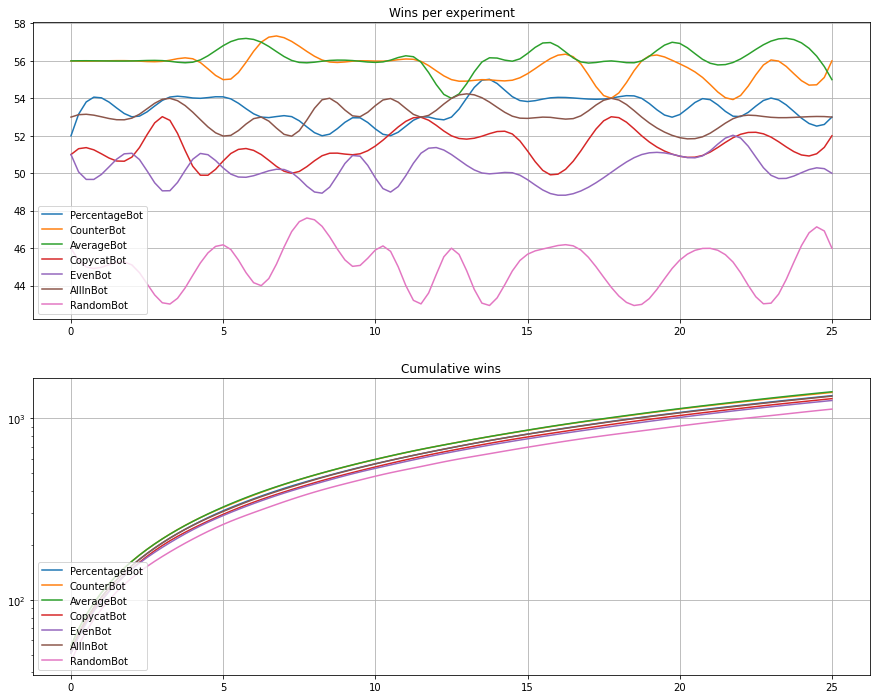

In [85]:
scores, totals = simulate(experiments, rounds, init_balance=50000)
plot_experiments(experiments, scores)

### Second Price Auction with initial balance

End of simulation
CopycatBot           Wins: 1721   Total Spent: 1229830   Avg Spent per Win: 714.60
AllInBot             Wins: 1710   Total Spent: 1239647   Avg Spent per Win: 724.94
EvenBot              Wins: 1681   Total Spent: 1239152   Avg Spent per Win: 737.15
PercentageBot        Wins: 1676   Total Spent: 1226569   Avg Spent per Win: 731.84
RandomBot            Wins: 1629   Total Spent: 1228133   Avg Spent per Win: 753.92
CounterBot           Wins: 604    Total Spent: 418260    Avg Spent per Win: 692.48
AverageBot           Wins: 104    Total Spent: 67005     Avg Spent per Win: 644.28


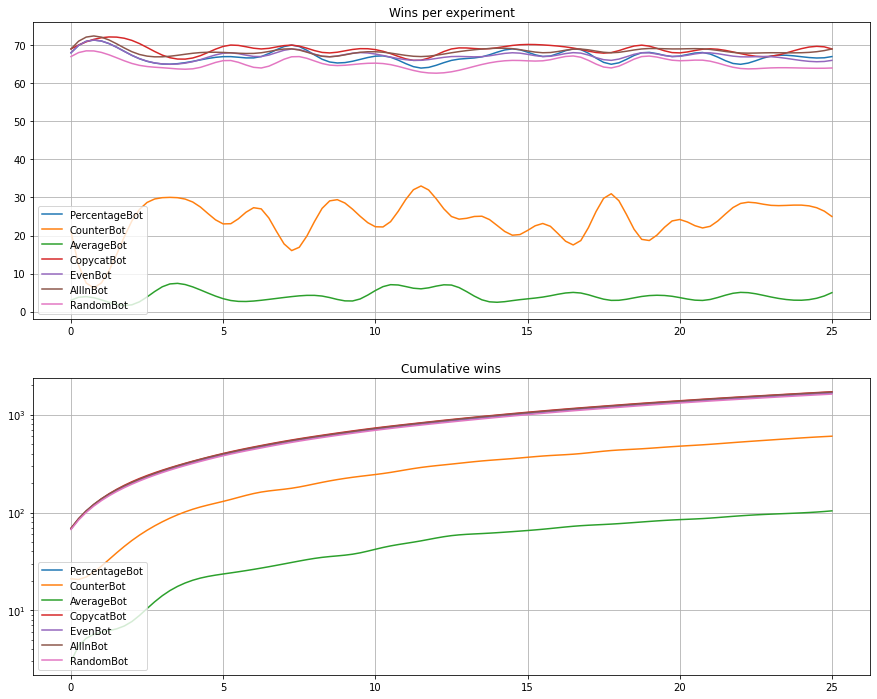

In [20]:
scores, totals = simulate(experiments, rounds, init_balance=50000, first_price=False)
plot_experiments(experiments, scores)

### First Price Auction with given balance per round

End of simulation
AverageBot           Wins: 1393   Total Spent: 4524048   Avg Spent per Win: 3247.70
CounterBot           Wins: 1383   Total Spent: 4513745   Avg Spent per Win: 3263.73
AllInBot             Wins: 1354   Total Spent: 4527500   Avg Spent per Win: 3343.80
PercentageBot        Wins: 1343   Total Spent: 4466653   Avg Spent per Win: 3325.88
CopycatBot           Wins: 1321   Total Spent: 4511088   Avg Spent per Win: 3414.90
EvenBot              Wins: 1210   Total Spent: 4528500   Avg Spent per Win: 3742.56
RandomBot            Wins: 1121   Total Spent: 4494784   Avg Spent per Win: 4009.62


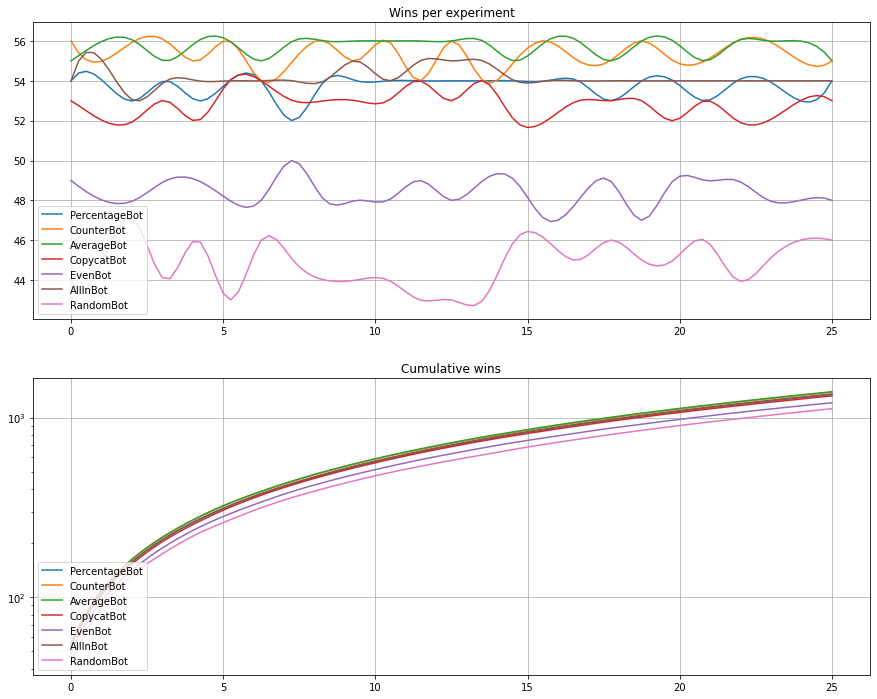

In [21]:
scores, totals = simulate(experiments, rounds, bal_per_round=500)
plot_experiments(experiments, scores)

### Second Price Auction with given balance per round

End of simulation
PercentageBot        Wins: 1519   Total Spent: 4462464   Avg Spent per Win: 2937.76
AllInBot             Wins: 1489   Total Spent: 4518900   Avg Spent per Win: 3034.86
CounterBot           Wins: 1482   Total Spent: 4515853   Avg Spent per Win: 3047.13
EvenBot              Wins: 1479   Total Spent: 4518651   Avg Spent per Win: 3055.21
CopycatBot           Wins: 1455   Total Spent: 4365825   Avg Spent per Win: 3000.57
RandomBot            Wins: 1434   Total Spent: 4473468   Avg Spent per Win: 3119.57
AverageBot           Wins: 267    Total Spent: 716712    Avg Spent per Win: 2684.31


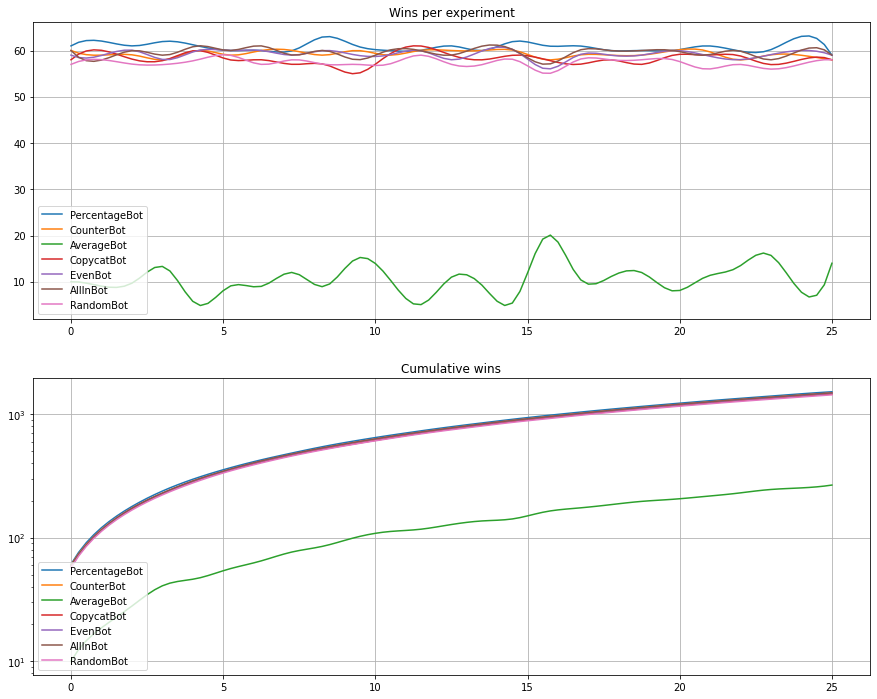

In [88]:
scores, totals = simulate(experiments, rounds, bal_per_round=500, first_price = False)
plot_experiments(experiments, scores)